In [6]:
from typing import Callable, Tuple
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sympy

In [7]:
from utils.montecarlo import monte_carlo, MonteCarloEstimate
from importance_sampling.importance_sampling import *

# Goal and Setup ## Rare Event Estimation

We want to estimate the probability of a rare event under a standard normal random variable  
$$
X \sim \mathcal{N}(0,1).
$$

Consider the tail event  
$$
A = \{x \ge 4.5\}.
$$

The probability of interest is  
$$
p = \mathbb{P}(X \ge 4.5)
  = \int_{4.5}^{\infty} \frac{1}{\sqrt{2\pi}} e^{-x^2/2}\,dx.
$$

Using symbolic integration (for example with SymPy), we obtain the numerical value  
$$
p = 3.39767312476808\times 10^{-6}.
$$

This is a very small number: the event happens roughly three to four times in a million independent standard normal draws.

Our goals in this note are:

- to define the plain Monte Carlo estimator and the importance sampling estimator for this probability,
- to derive the expectation and variance of the plain Monte Carlo estimator,
- to use the central limit theorem (CLT) to understand how many samples plain Monte Carlo needs,
- to see why that sample size is astronomically large for this rare event,
- to introduce an importance sampling estimator with a better proposal distribution,
- to derive and interpret the variance of the importance sampling estimator and explain why it can be much smaller than the Monte Carlo variance.

Throughout, we will use the notation:

- $\mathbb{E}_f$ for expectations when $X \sim f$ (the target standard normal density),
- $\mathbb{E}_g$ for expectations when $X \sim g$ (the proposal density),
- $\hat{p}_n^{MC}$ for the Monte Carlo estimator,
- $\hat{p}_n^{IS}$ for the importance sampling estimator.


In [3]:
# x-range in the rare-event region
x = np.linspace(4.5, 10, 1000)

# PDFs
pdf_exp  = stats.expon.pdf(x, loc=4.5)
pdf_norm = stats.norm.pdf(x)

# Plot
plt.plot(x, pdf_exp,  label="Exponential Proposal")
plt.plot(x, pdf_norm, label="Standard Normal Target")

plt.xlabel("z")
plt.ylabel("PDF")
plt.legend()
plt.show()

## Analytical Value of the Rare Event Probability

In [8]:
z = sympy.Symbol('z')
fz = sympy.exp(-z**2 /2)/sympy.sqrt(2 * sympy.pi)
Pz = sympy.integrals.integrate(fz, (z, 4.5, sympy.oo)).evalf()
print("Analytical Solution: ", Pz)

Analytical Solution:  3.39767312476808e-6


This value is treated as the ground truth. Every estimator we build is trying to recover this number from random samples.

## Vaniall Monte Carlo

### Definition

Let  
$$
X \sim f = \mathcal{N}(0,1).
$$

We can write the probability as an expectation under $f$:  
$$
p = \mathbb{P}_f(X \ge 4.5)
  = \mathbb{E}_f\big[\mathbf{1}_{\{X \ge 4.5\}}\big].
$$

Define the Bernoulli random variable  
$$
Y = \mathbf{1}_{\{X \ge 4.5\}} \in \{0,1\}.
$$

Then  
$$
\mathbb{E}_f[Y] = p,
\qquad
\operatorname{Var}_f(Y) = p(1-p).
$$

Given i.i.d. draws  
$$
X_1,\dots,X_n \sim f,
$$
we define the Monte Carlo estimator  
$$
\hat{p}_n^{MC}
=
\frac{1}{n}\sum_{i=1}^n \mathbf{1}_{\{X_i \ge 4.5\}}
=
\frac{1}{n}\sum_{i=1}^n Y_i.
$$

### Expectation and Variance of $\hat{p}_n^{MC}$

Unbiasedness:
$$
\mathbb{E}_f[\hat{p}_n^{MC}]
=
\mathbb{E}_f\left[\frac{1}{n}\sum_{i=1}^n Y_i\right]
=
\frac{1}{n}\sum_{i=1}^n \mathbb{E}_f[Y_i]
=
\frac{1}{n}\cdot n\,\mathbb{E}_f[Y]
=
p.
$$

So $\hat{p}_n^{MC}$ is an unbiased estimator of $p$:  
$$
\mathbb{E}_f[\hat{p}_n^{MC}] - p = 0.
$$

Variance:
$$
\operatorname{Var}_f(\hat{p}_n^{MC})
=
\operatorname{Var}_f\left(\frac{1}{n}\sum_{i=1}^n Y_i\right)
=
\frac{1}{n^2}\sum_{i=1}^n \operatorname{Var}_f(Y_i)
=
\frac{1}{n^2}\cdot n\,p(1-p)
=
\frac{p(1-p)}{n}.
$$

The Monte Carlo standard error is therefore  
$$
\sqrt{\operatorname{Var}_f(\hat{p}_n^{MC})}
=
\sqrt{\frac{p(1-p)}{n}}.
$$

For a rare event with very small $p$, this variance will be roughly $p/n$, which is tiny numerically but problematic because almost all of the individual samples are zeros.


### Numerical Result for $n=100{,}000$

Consider the experiment with $n = 100{,}000$ samples from the standard normal:

In [9]:
num_samples = 100000
standard_normal_sampler = np.random.randn

def g_evaluator(x: np.ndarray) -> np.ndarray:
    return x > 4.5

Pz_mc_estimate = monte_carlo(num_samples, standard_normal_sampler, g_evaluator, cumsum=False)
print(f"MC estimate with {num_samples:,} samples = {Pz_mc_estimate.estimate:5E}")
print(f"Truth                         = {Pz:5E}")

MC estimate with 100,000 samples = 0.000000E+00
Truth                         = 3.39767312476808E-6


Numerically we obtain  
$$
\hat{p}_{100000}^{MC} = 0,
\qquad
p = 3.39767312476808\times 10^{-6}.
$$

This is not a numerical bug. For this event, $p$ is so small that with $100{,}000$ standard normal samples we expect less than one hit on average:  
$$
n p = 100{,}000 \times 3.4\times 10^{-6} \approx 0.34.
$$

So it is more likely than not that we see no hits at all and the estimator outputs zero.


## How Many Samples Does MC Need? CLT and Relative Error

### CLT for the Bernoulli Average

Recall:  
$$
Y_i = \mathbf{1}_{\{X_i \ge 4.5\}},\quad X_i \sim f,\quad
Y_i \sim \text{Bernoulli}(p),
$$
and  
$$
\hat{p}_n^{MC} = \frac{1}{n}\sum_{i=1}^n Y_i.
$$

We have  
$$
\mathbb{E}_f[Y_i] = p,
\qquad
\operatorname{Var}_f(Y_i) = p(1-p).
$$

By the central limit theorem (CLT),  
$$
\sqrt{n}\,\frac{\hat{p}_n^{MC} - p}{\sqrt{p(1-p)}} 
\;\overset{d}{\longrightarrow}\; N(0,1),
$$
so for large $n$, the standardized error  
$$
\frac{\hat{p}_n^{MC} - p}{\sqrt{p(1-p)/n}}
$$
is approximately standard normal.

---

### Relative Error and Confidence Level

We want to control the relative error:  
$$
\frac{|\hat{p}_n^{MC} - p|}{p} \le \varepsilon
\quad\Longleftrightarrow\quad
|\hat{p}_n^{MC} - p| \le \varepsilon p,
$$
for some tolerance $\varepsilon > 0$.

We also want this to hold with confidence $1-\alpha$ (for example $1-\alpha = 0.95$).  
Let $q_{1-\alpha/2}$ denote the $(1-\alpha/2)$ quantile of the standard normal distribution. For $95\%$ confidence,  
$$
\alpha = 0.05,
\qquad
q_{0.975} \approx 1.96.
$$

Under the CLT approximation,  
$$
\mathbb{P}\left(
\left|\frac{\hat{p}_n^{MC} - p}{\sqrt{p(1-p)/n}}\right|
\le
q_{1-\alpha/2}
\right)
\approx 1-\alpha.
$$

To enforce the relative error constraint within this probability, we require  
$$
\frac{\varepsilon p}{\sqrt{p(1-p)/n}} = q_{1-\alpha/2}.
$$
This equation gives us a design rule for $n$.

---

### Solving for $n$

Starting from  
$$
\frac{\varepsilon p}{\sqrt{p(1-p)/n}} = q_{1-\alpha/2},
$$
square both sides:  
$$
\frac{\varepsilon^2 p^2}{p(1-p)/n} = q_{1-\alpha/2}^2.
$$

Rearrange to isolate $n$:  
$$
\varepsilon^2 p^2 \cdot \frac{n}{p(1-p)} = q_{1-\alpha/2}^2
\quad\Longrightarrow\quad
n = \frac{q_{1-\alpha/2}^2\,p(1-p)}{\varepsilon^2 p^2}
=
\frac{q_{1-\alpha/2}^2(1-p)}{\varepsilon^2 p}.
$$

For a rare event with $p\ll 1$, we can approximate $(1-p)\approx 1$, so  
$$
n \approx \frac{q_{1-\alpha/2}^2}{\varepsilon^2 p}.
$$

This shows two things:

- The sample size grows like $1/(\varepsilon^2 p)$ as $p$ becomes small.
- For very small $p$, the required number of samples explodes.

---

### Numerical Example: 10% Relative Error at 95% Confidence

Now plug in the specific values  
$$
p = 3.39767312476808\times 10^{-6},
\qquad
\varepsilon = 0.1,
\qquad
1-\alpha = 0.95,
\qquad
q_{0.975} = 1.96.
$$

Then  
$$
n \approx \frac{1.96^2}{(0.1)^2\,p}
=
\frac{3.8416}{0.01\,p}
=
\frac{384.16}{p}.
$$

Substituting our $p$:  
$$
n \approx \frac{384.16}{3.39767312476808\times 10^{-6}}
  \approx 1.13\times 10^8.
$$

So we need roughly  
$$
n \approx 113\,\text{million samples}
$$
to get $10\%$ relative error with $95\%$ confidence using plain Monte Carlo.

---

### Interpretation: How Often Do We See a One?

The true probability is  
$$
p = 3.39767312476808\times 10^{-6}.
$$

On average, we see one success (one hit in the tail) every  
$$
\frac{1}{p} \approx 294{,}300
$$
standard normal samples.

That means:

- In a block of about $300{,}000$ samples, we typically see one $1$ and almost $299{,}999$ zeros.
- To build a stable estimator with small relative error, we need many such successes, not just one or two.
- The CLT calculation tells us that to have enough successes to shrink the relative error to $10\%$, we should plan for on the order of $10^8$ samples.

In practice, this is not just a large number. For a realistic simulation where each sample may involve a physics engine, a robot dynamics model, or a complicated likelihood evaluation, $113$ million evaluations is simply too expensive.

The Monte Carlo estimator remains unbiased, but its convergence is squeezed by the fact that almost every sample contributes a zero to the estimator. The zeros dominate, the rare ones are too infrequent, and the relative error decays painfully slowly.

This is the core failure mode of plain Monte Carlo for rare events: the distribution we sample from almost never visits the event we care about.


## Importance Sampling Estimator

To fix this, we change *where* we sample from. Instead of drawing $X$ from $f$ and almost never seeing the event $A$, we draw $X$ from a proposal distribution $g$ that places most of its mass inside $A$.

### Choice of Proposal

We choose $g$ to be an exponential distribution shifted to start at $4.5$:
$$
g(x) =
\begin{cases}
e^{-(x-4.5)}, & x \ge 4.5,\\[4pt]
0, & x < 4.5.
\end{cases}
$$

Under this proposal, almost every sampled $X$ lies in the region $x \ge 4.5$, so the rare event is not rare under $g$.

### Rewriting the Probability Under $g$

We can rewrite $p$ as an expectation under $g$ using the identity  
$$
f(x)\,dx = \frac{f(x)}{g(x)} g(x)\,dx
$$
whenever $g(x)>0$. For our indicator integrand,
$$
p = \int_{4.5}^{\infty} \phi(x)\,dx
  = \int_{4.5}^{\infty} \mathbf{1}_{\{x\ge 4.5\}}\,\phi(x)\,dx
  = \int_{4.5}^{\infty} \mathbf{1}_{\{x\ge 4.5\}}\,\frac{\phi(x)}{g(x)}\,g(x)\,dx.
$$

Define the weight  
$$
w(x) = \frac{f(x)}{g(x)} = \frac{\phi(x)}{g(x)},
$$
for $x \ge 4.5$. Then  
$$
p = \mathbb{E}_g\big[\mathbf{1}_{\{X \ge 4.5\}}\,w(X)\big],
$$
where $\mathbb{E}_g$ denotes expectation when $X \sim g$.

### Definition of $\hat{p}_n^{IS}$ and Unbiasedness

Given i.i.d. draws  
$$
X_1,\dots,X_n \sim g,
$$
the importance sampling estimator is  
$$
\hat{p}_n^{IS}
=
\frac{1}{n}\sum_{i=1}^n \mathbf{1}_{\{X_i \ge 4.5\}}\,w(X_i).
$$

Unbiasedness:
$$
\mathbb{E}_g[\hat{p}_n^{IS}]
=
\mathbb{E}_g\left[\frac{1}{n}\sum_{i=1}^n \mathbf{1}_{\{X_i \ge 4.5\}}\,w(X_i)\right]
=
\frac{1}{n}\sum_{i=1}^n \mathbb{E}_g\big[\mathbf{1}_{\{X_i \ge 4.5\}}\,w(X_i)\big]
=
\mathbb{E}_g\big[\mathbf{1}_{\{X \ge 4.5\}}\,w(X)\big]
=
p.
$$

So $\hat{p}_n^{IS}$ is also an unbiased estimator of $p$.


## Numerical Result with Importance Sampling

We now implement the importance sampling estimator using the shifted exponential proposal and compare it to the analytical truth.


In [10]:
def proposal_sampler(n: int) -> np.ndarray:
    return stats.expon.rvs(size=n, loc=4.5, scale = 1)

def proposal_pdf(x: np.ndarray) ->np.ndarray:
    return stats.expon.pdf(x, loc=4.5, scale = 1)

def target_pdf(x: np.ndarray) -> np.ndarray:
    return stats.norm.pdf(x)

Pz_is = importance_sampling(num_samples,proposal_sampler,proposal_pdf,target_pdf, g_evaluator, False)
print(f"Important Sampling estimate with {num_samples:,} samples = {Pz_is.estimate_is:5E}")
print(f"Truth                         = {Pz:5E}")


Important Sampling estimate with 100,000 samples = 3.398015E-06
Truth                         = 3.39767312476808E-6


With $n = 100{,}000$ samples from the proposal $g$, we obtain:
$$
\hat{p}_n^{IS} \approx 3.390223\times 10^{-6},
\qquad
p = 3.39767312476808\times 10^{-6}.
$$

Compare this with plain Monte Carlo using the same $100{,}000$ samples from $f$:
$$
\hat{p}_n^{MC} = 0.
$$

For the same computational budget ($n = 10^5$ sample evaluations),

- plain Monte Carlo completely misses the rare event and returns zero,
- importance sampling produces an estimate **extremely** close to the analytical truth.

The difference is not a small constant factor. Plain Monte Carlo needs on the order of $113$ million samples to achieve $10\%$ relative error with $95\%$ confidence. Importance sampling, with a well-chosen proposal, achieves a good approximation to the true rare-event probability with only $100{,}000$ samples.

This is exactly why importance sampling is essential in rare event estimation: it changes the sampling distribution so that the event of interest is frequently observed, and then uses weights to correct back to the original target distribution.


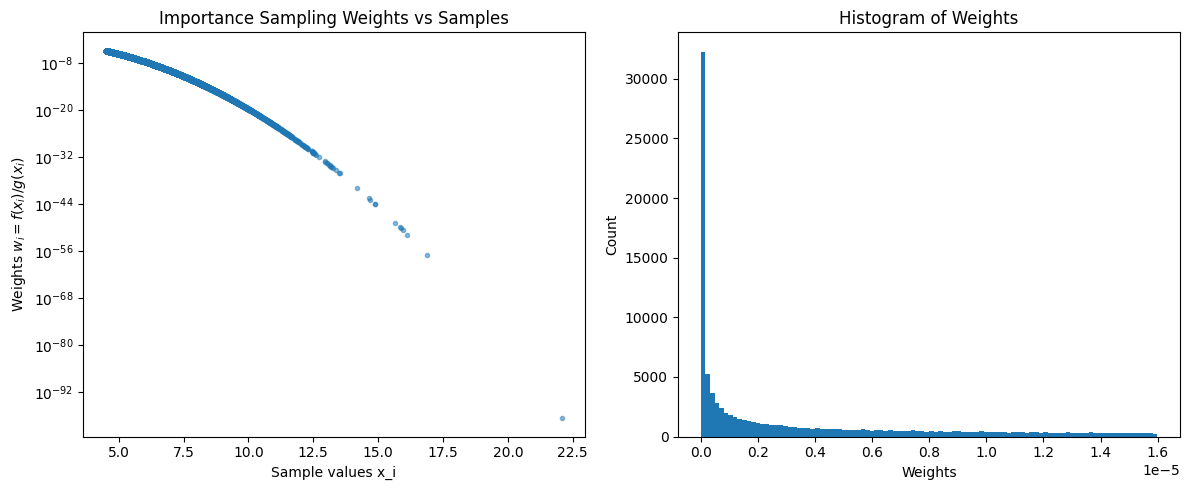

In [11]:
# Extract arrays
x = Pz_is.x_samples
w = Pz_is.w_raw

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# -----------------------------------------
# 1. Weights vs x (log scale is important)
# -----------------------------------------
ax1.semilogy(x, w, 'o', markersize=3, alpha=0.5)
ax1.set_xlabel("Sample values x_i")
ax1.set_ylabel(r"Weights $w_i = f(x_i)/g(x_i)$")
ax1.set_title("Importance Sampling Weights vs Samples")

# -----------------------------------------
# 2. Histogram of weights
# -----------------------------------------
ax2.hist(w, bins=100)
ax2.set_xlabel("Weights")
ax2.set_ylabel("Count")
ax2.set_title("Histogram of Weights")

plt.tight_layout()
plt.show()
